In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "anindya2306"

# username from the json file

os.environ['KAGGLE_KEY'] = "aa5cbd40ed5286f76f32e2947bf4fdc5"

# key from the json file

In [3]:
!kaggle datasets download -d jakeshbohaju/brain-tumor

 93% 13.0M/14.0M [00:01<00:00, 13.9MB/s]
100% 14.0M/14.0M [00:01<00:00, 8.19MB/s]


In [4]:
!unzip -q "/content/brain-tumor.zip"

# Importing Libraries

In [5]:
!pip install keras_tuner elasticdeform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 14.1 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, InputLayer
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters
import warnings
warnings.filterwarnings('ignore')

# Reading the data:

This dataframe contains handcrafted features.

In [22]:
df = pd.read_csv('/content/Brain Tumor.csv')
df['Class'] = df['Class'].map({1:"Tumor", 0:"Normal"})
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,Normal,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,Normal,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,Tumor,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,Tumor,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,Normal,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


This dataframe contains bounding boxes. We'll be using this one.

In [5]:
df = pd.read_csv("/content/drive/MyDrive/BrainTumor2/Brain Tumor/box_label.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df.head()

,image,class,bbox
0,Image1.jpg,0,"[0.38333332538604736, 0.7083333134651184, 0.17..."
1,Image10.jpg,1,"[0.5645833611488342, 0.4791666567325592, 0.237..."
2,Image100.jpg,0,"[0.643750011920929, 0.46875, 0.145833328366279..."
3,Image100.jpg,0,"[0.3499999940395355, 0.47083333134651184, 0.16..."
4,Image1000.jpg,0,"[0.3541666567325592, 0.4229166805744171, 0.108..."


In [6]:
import cv2

path = '/content/Brain Tumor/Brain Tumor/'
files = os.listdir(path)

input_size = 240

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

In [9]:
#Viewing a sample image
# i = 234
# plt.imshow(images_f[i], cmap = 'bone')
# print(f'The label is: {classes_f[i]}')

Text(0, 0.5, 'Distribution')

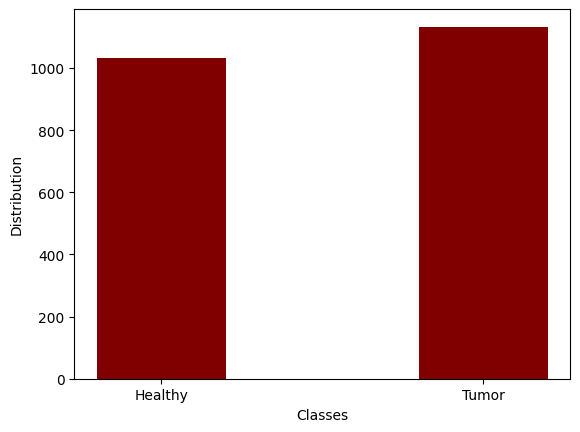

In [10]:
#Inspecting the prior distribution of each class

counts = df["class"].sum()
n = len(df)
plt.bar([0, 1], [n-counts, counts], color ='maroon', width = 0.4)
plt.xticks([0, 1], ['Healthy', 'Tumor'])
plt.xlabel('Classes')
plt.ylabel('Distribution')


# Defining Data-loader for our CNN model:

In [12]:
import elasticdeform
import random
import ast

In [13]:
def brightness(X, y):
    """
    Changing the brighness of a image using power-law gamma transformation.
    Gain and gamma are chosen randomly for each image channel.

    Gain chosen between [0.8 - 1.2]
    Gamma chosen between [0.8 - 1.2]

    new_im = gain * im^gamma
    """
    X_new = np.zeros(X.shape)
    gain, gamma = (1.2 - 0.8) * np.random.random_sample(2,) + 0.8
    X_new = np.sign(X)*gain*(np.abs(X)**gamma)

    return X_new, y

def elastic(X, y):
    """
    Elastic deformation on a image and its target
    """

    Xel = elasticdeform.deform_random_grid(X, sigma=1, axis= (0, 1), order= 1, mode='constant')

    return Xel, y

def translation(X, y):
    height, width = X.shape[:2]
    x_, y_, w_, h_, c_ = y
    height_lim, width_lim = height // 5, width // 5
    tx = random.randint(-height_lim, height_lim)
    ty = random.randint(-width_lim, width_lim)

    T = np.float32([[1, 0, tx], [0, 1, ty]])

    # We use warpAffine to transform
    # the image using the matrix, T
    X_new = cv2.warpAffine(X, T, (width, height))
    y_new = np.array([x_ + tx, y_ + ty, w_, h_, c_])
    return X_new, y_new


def combine_aug(X, y):
    """
    Combine randomly the different augmentation techniques written above
    """
    decision = random.randint(0, 1)

    if decision == 1:
        Xnew, ynew = brightness(X, y)

    if decision == 0:
        Xnew, ynew = translation(X, y)

    return Xnew, ynew


def data_load(df, full_data_path = '/content/Brain Tumor/Brain Tumor/'):
    X = []
    Y = []

    for i in range(len(df)):
        fle = df.iloc[i]["image"]
        img = cv2.imread(os.path.join(full_data_path, fle), cv2.IMREAD_GRAYSCALE)

        k = df.iloc[i]["class"]

        bbox_str = df.iloc[i]["bbox"]

        # Convert the string to a list
        bbox_list = ast.literal_eval(bbox_str)

        # Convert the list to a NumPy array
        bbox_array = np.array(bbox_list, dtype=float)

        img, box = format_image(img, bbox_array)
        img = img.astype(float) / 255.0
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        img_new1, label_new1 = combine_aug(img, label)

        X.append(img)
        Y.append(label)
        X.append(img_new1)
        Y.append(label_new1)


    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [14]:
df_sampled = df.sample(frac = 1.0)
n = len(df_sampled)
val_split = 0.2
d_val = df.copy().iloc[:int(val_split*n), :]
d_train = df.copy().iloc[int(val_split*n):, :]

raw_train_ds = data_load(d_train)
raw_validation_ds = data_load(d_val)

In [15]:
# Example string representing a bounding box
bbox_str = '[0.3541666567325592, 0.4583333432674408, 0.17499999701976776, 0.22499999403953552]'

# Convert the string to a list
bbox_list = ast.literal_eval(bbox_str)

# Convert the list to a NumPy array
bbox_array = np.array(bbox_list, dtype=float)

bbox_array


array([0.35416666, 0.45833334, 0.175     , 0.22499999])

In [16]:
def format_instance(image, label):
    return image, ([int(label[4])], [label[0], label[1], label[2], label[3]])

In [17]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
train_ds = tune_training_ds(raw_train_ds)

In [19]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(d_val) // 4)
    dataset = dataset.repeat()
    return dataset

In [20]:
validation_ds = tune_validation_ds(raw_validation_ds)

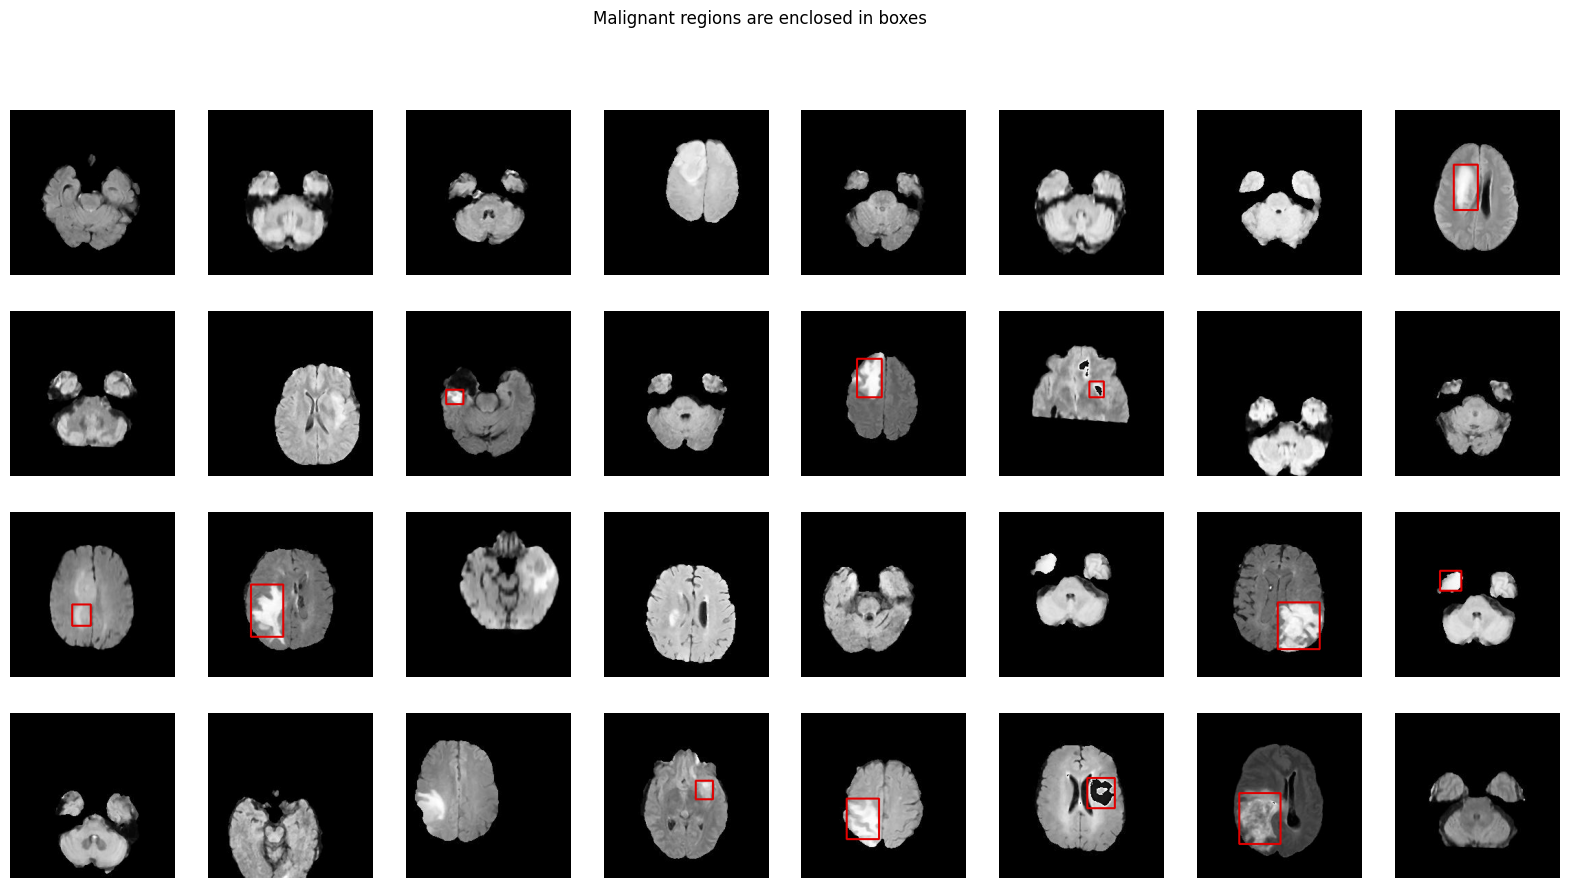

In [79]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        color = (225, 0, 0)

        if label[0] == 1:
          cv2.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.suptitle("Malignant regions are enclosed in boxes")
        plt.axis("off")

# CNN Model Creation & Training:

In [40]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(filters=16,kernel_size=5, activation="relu", input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    # x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    # x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    return x


def build_classifier_head(inputs):
  return tf.keras.layers.Dense(1, activation='sigmoid', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    x =  tf.keras.layers.Dense(units = 32, name = 'regressor_body')(inputs)
    x = tf.keras.layers.Dense(units = 4, name = 'regressor_head')(x)
    return x


def build_model(inputs):

    features = build_feature_extractor(inputs)

    classification_head = build_classifier_head(features)

    regressor_head = build_regressor_head(features)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : ['accuracy', f1_m] , 'regressor_head' : 'mae' })

    return model

In [41]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 236, 236, 16)         416       ['input_3[0][0]']             
                                                                                                  
 average_pooling2d_6 (Avera  (None, 118, 118, 16)         0         ['conv2d_6[0][0]']            
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_7 (Conv2D)           (None, 116, 116, 32)         4640      ['average_pooling2d_6[0]

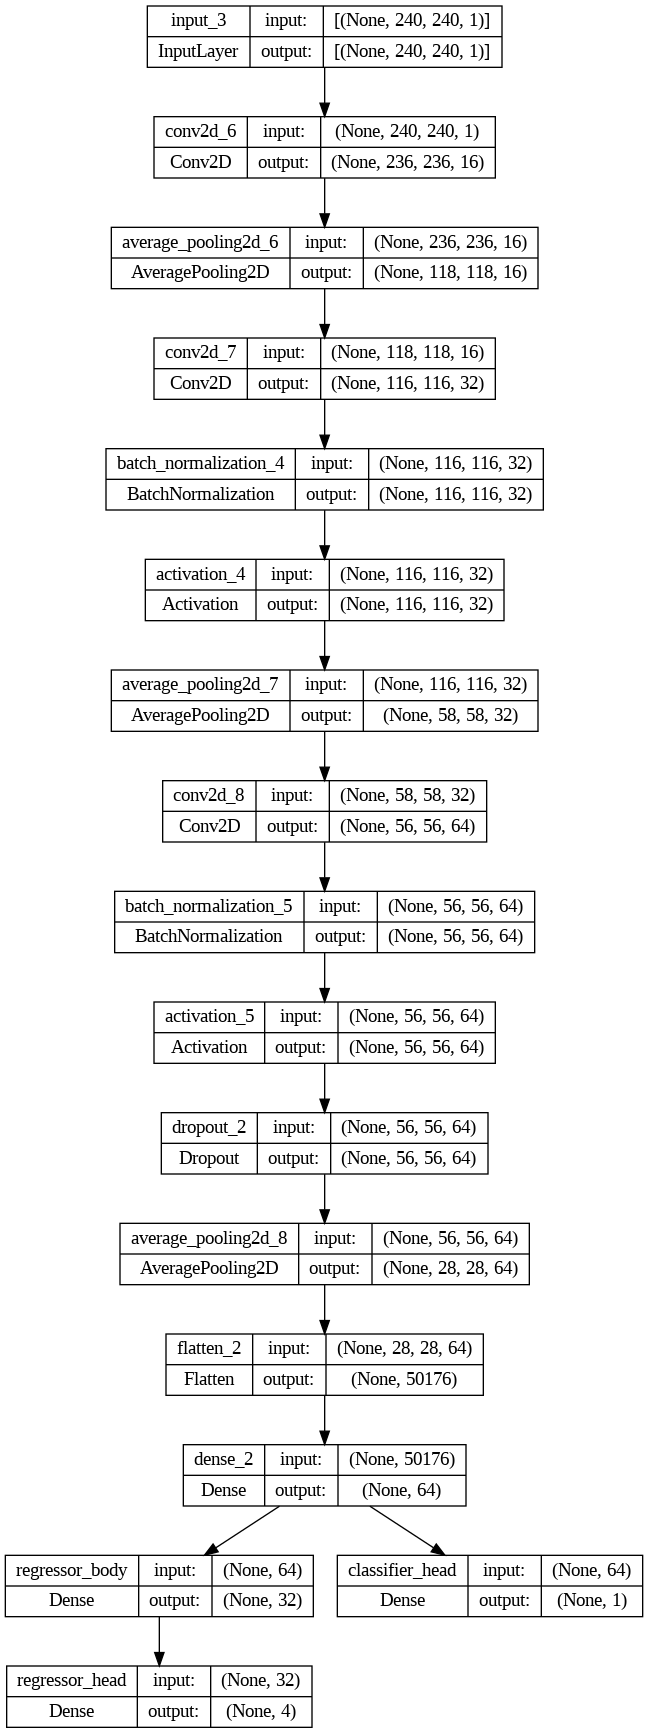

In [42]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [43]:
EPOCHS = 150

history = model.fit(train_ds,
                    steps_per_epoch=(len(d_train) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/150
54/54 [==============================] - 6s 64ms/step - loss: 33.2558 - classifier_head_loss: 0.7981 - regressor_head_loss: 32.4577 - classifier_head_accuracy: 0.7604 - classifier_head_f1_m: 0.7634 - regressor_head_mae: 2.8781 - val_loss: 84.4114 - val_classifier_head_loss: 0.7255 - val_regressor_head_loss: 83.6859 - val_classifier_head_accuracy: 0.3889 - val_classifier_head_f1_m: 0.5600 - val_regressor_head_mae: 3.3643
Epoch 2/150
54/54 [==============================] - 3s 60ms/step - loss: 9.4963 - classifier_head_loss: 0.3050 - regressor_head_loss: 9.1913 - classifier_head_accuracy: 0.8721 - classifier_head_f1_m: 0.8701 - regressor_head_mae: 1.7090 - val_loss: 76.9144 - val_classifier_head_loss: 1.0767 - val_regressor_head_loss: 75.8377 - val_classifier_head_accuracy: 0.3889 - val_classifier_head_f1_m: 0.5600 - val_regressor_head_mae: 3.9806
Epoch 3/150
54/54 [==============================] - 4s 67ms/step - loss: 5.2182 - classifier_head_loss: 0.2405 - regressor_head_l

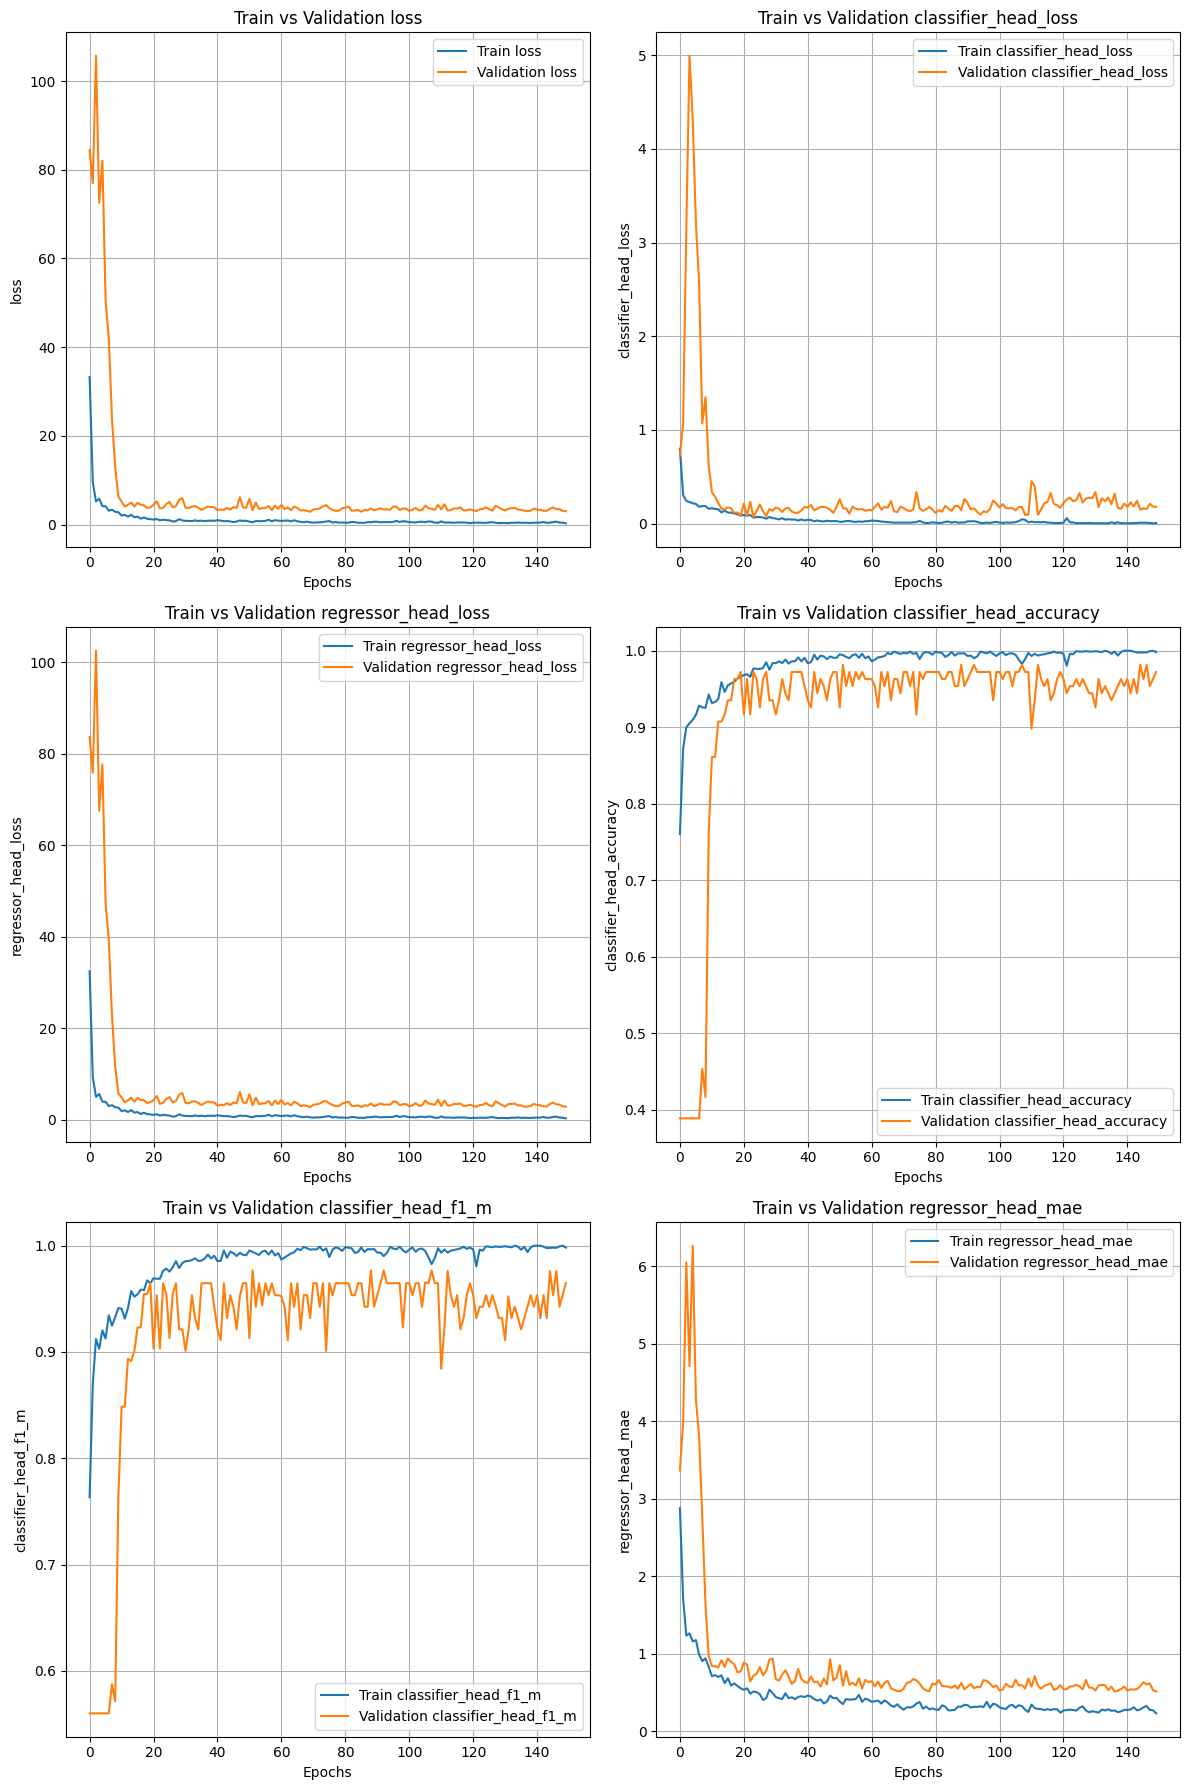

In [44]:
metrics = [
    "loss",
    "classifier_head_loss",
    "regressor_head_loss",
    "classifier_head_accuracy",
    "classifier_head_f1_m",
    "regressor_head_mae"
]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Iterate over the metrics and plot them
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]  # Determine the position on the grid
    ax.plot(history.history[metric], label=f'Train {metric}')
    ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    ax.set_title(f'Train vs Validation {metric}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid("on")

plt.tight_layout()
plt.show()



## Keras Tuner (optional)

In [ ]:
# def build_model(hp):
#     '''
#     In the previous model hyper-parameters were fixed.
#     We need to define the model over some range of hyperparameters to tune it later.
#     '''
#     model = keras.Sequential([
#     keras.layers.InputLayer(input_shape = (240, 240, 3)),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
#         activation='relu',
#         padding="same",
#         input_shape=(240, 240, 3)
#     ),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
#         activation='relu',
#         padding="same"
#     ),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
#         activation='relu',
#         padding="same"
#     ),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
#         activation='relu',
#         padding="same"
#     ),
#     keras.layers.MaxPool2D(),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(
#         units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
#         activation='relu'
#     ),
#     keras.layers.Dropout(rate=0.3),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(
#         units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
#         activation='relu'
#     ),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(rate=0.3),
#     keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model.compile(optimizer=keras.optimizers.Adam(1e-3),#hp.Choice('learning_rate', values=[1e-2, 1e-3])),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model

In [ ]:
# # Defining keras tuner object
# tuner_search=RandomSearch(build_model,
#                           objective='val_accuracy',
#                           max_trials=8,directory='output',project_name="Brain tumor classification"
#                          )

In [ ]:
# tuner_search.search(images_f[:threshold],classes_f[:threshold],epochs=15,validation_split=0.3)

In [ ]:
# model = tuner_search.get_best_models(num_models=1)[0]
# model.summary()

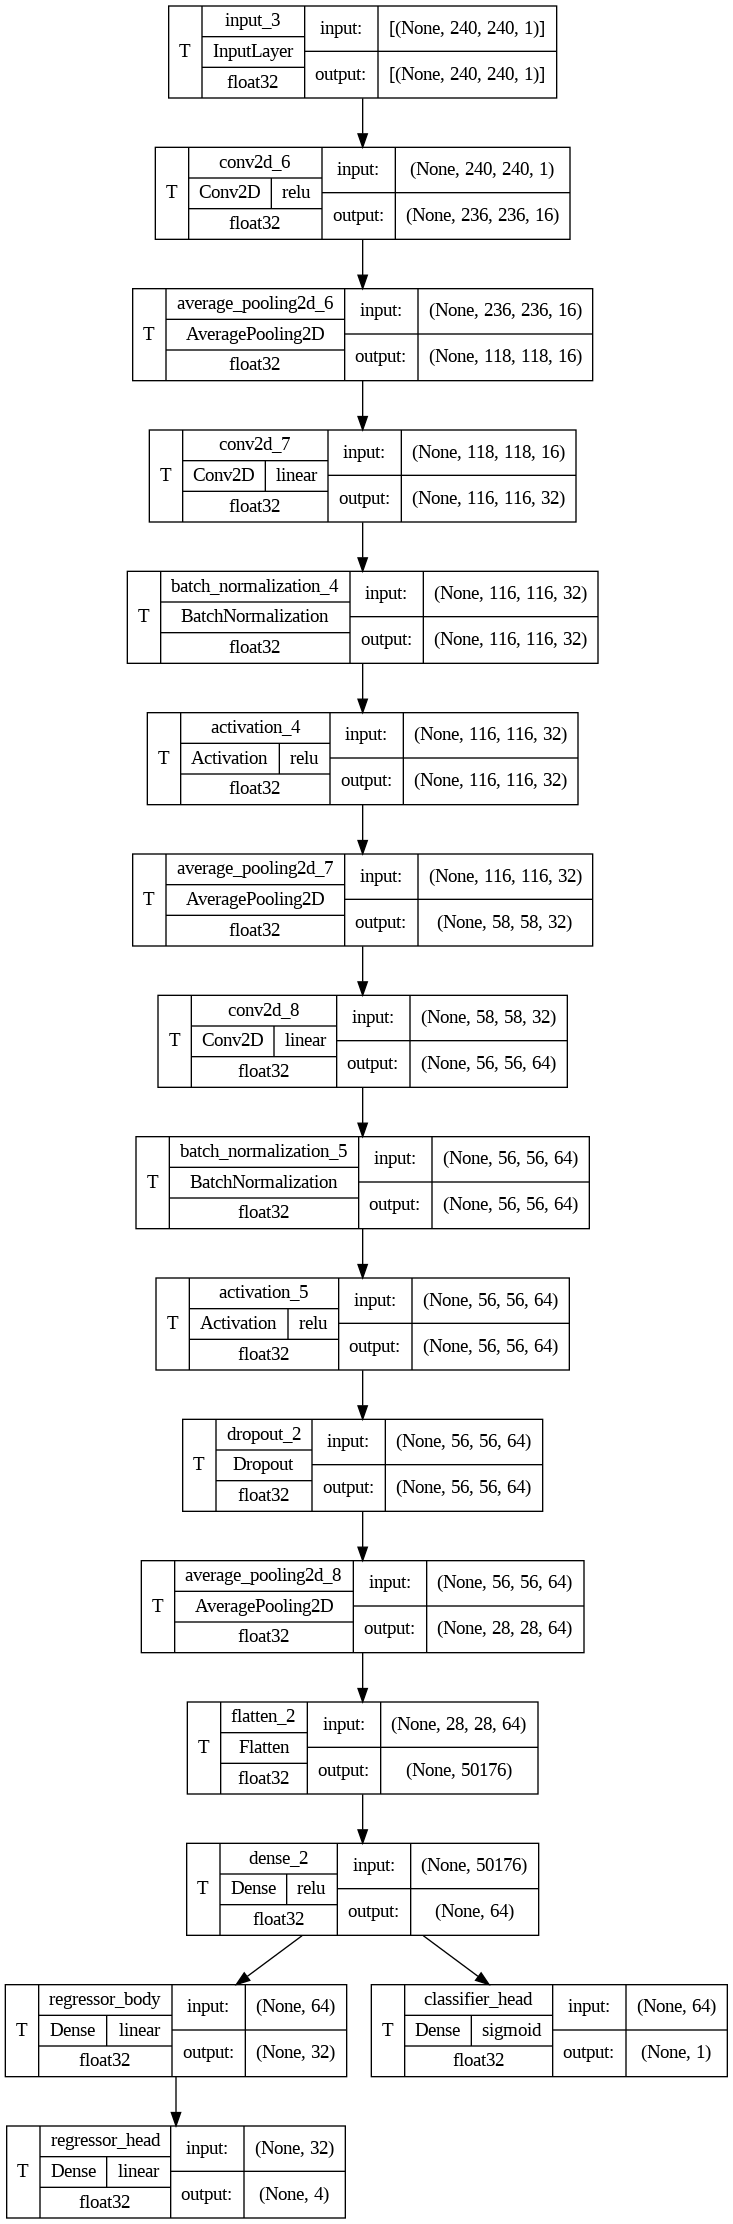

In [50]:
# This shows a pictorial representation of the model
tf.keras.utils.plot_model(
    model, to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
    show_trainable=True
)

In [48]:
m = np.min(history.history['val_loss'])
i = np.argmin(history.history['val_loss'])
print('Minimum validation loss: ' + str(m)+' and validation accuracy: ' + str(history.history['val_classifier_head_accuracy'][i]*100) + ' %')
print('after iteration no. ' + str(i+1) +'.')

Minimum validation loss: 2.90895938873291 and validation accuracy: 94.44444179534912 %
after iteration no. 70.


In [51]:
model.save_weights("/content/drive/MyDrive/BrainTumor2/Weights_23_11/")

In [65]:
for layer in model.layers:
  print(layer.name, ":\t", layer.output.shape)

input_3 :	 (None, 240, 240, 1)
conv2d_6 :	 (None, 236, 236, 16)
average_pooling2d_6 :	 (None, 118, 118, 16)
conv2d_7 :	 (None, 116, 116, 32)
batch_normalization_4 :	 (None, 116, 116, 32)
activation_4 :	 (None, 116, 116, 32)
average_pooling2d_7 :	 (None, 58, 58, 32)
conv2d_8 :	 (None, 56, 56, 64)
batch_normalization_5 :	 (None, 56, 56, 64)
activation_5 :	 (None, 56, 56, 64)
dropout_2 :	 (None, 56, 56, 64)
average_pooling2d_8 :	 (None, 28, 28, 64)
flatten_2 :	 (None, 50176)
dense_2 :	 (None, 64)
regressor_body :	 (None, 32)
classifier_head :	 (None, 1)
regressor_head :	 (None, 4)


In [68]:
ft_input = model.input
ft_layers = model.layers
features = tf.keras.models.Model(inputs = ft_input, outputs = ft_layers[-4].output)
features.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 236, 236, 16)      416       
                                                                 
 average_pooling2d_6 (Avera  (None, 118, 118, 16)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 batch_normalization_4 (Bat  (None, 116, 116, 32)      128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 116, 116, 32)      0   

In [70]:
from tqdm import tqdm
image_features = []
n = len(d_train)
for i in tqdm(range(n)):
    img_path = path + d_train.iloc[i]["image"]
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = np.array(image, dtype = np.float64)/255.0
    image = np.expand_dims(image, axis = 0)
    feat = features.predict(image, verbose = 0)
    image_features.append(feat)

image_features = np.array(image_features)
image_features.shape

100%|██████████| 1733/1733 [02:15<00:00, 12.78it/s]


(1733, 1, 64)

In [71]:
y = d_train["class"].to_numpy()
image_features = np.squeeze(image_features)
image_features.shape, y.shape

((1733, 64), (1733,))

In [73]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

lgbm_params = {
'learning_rate': 0.016305696769506942,
 'n_estimators': 800,
 'lambda_l1': 0.0018433685757398184,
 'lambda_l2': 0.0022098737089695656,
 'num_leaves': 174,
 'feature_fraction': 0.9827401596113596,
 'bagging_fraction': 0.724695129984146,
 'bagging_freq': 5,
 'min_child_samples': 79
 }

X_train, X_temp, y_train, y_temp = train_test_split(image_features, y, test_size=0.3)
model_classifier = lgbm.LGBMClassifier(**lgbm_params, verbose = -1)
model_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model_classifier.predict(X_temp)
# Calculate accuracy
accuracy = accuracy_score(y_temp, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_temp, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_temp, y_pred)
print("ROC-AUC Score:", roc_auc)

Accuracy: 0.9942307692307693
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       249
           1       1.00      0.99      0.99       271

    accuracy                           0.99       520
   macro avg       0.99      0.99      0.99       520
weighted avg       0.99      0.99      0.99       520

ROC-AUC Score: 0.994301930971117


In [74]:
model_classifier = lgbm.LGBMClassifier(**lgbm_params, verbose = -1)
model_classifier.fit(image_features, y)

LGBMClassifier(bagging_fraction=0.724695129984146, bagging_freq=5,
               feature_fraction=0.9827401596113596,
               lambda_l1=0.0018433685757398184, lambda_l2=0.0022098737089695656,
               learning_rate=0.016305696769506942, min_child_samples=79,
               n_estimators=800, num_leaves=174, verbose=-1)

In [75]:
image_features = []
n = len(d_val)
for i in tqdm(range(n)):
    img_path = path + d_val.iloc[i]["image"]
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = np.array(image, dtype = np.float64)/255.0
    image = np.expand_dims(image, axis = 0)
    feat = features.predict(image, verbose = 0)
    image_features.append(feat)

image_features = np.array(image_features)
y = d_val["class"].to_numpy()
image_features = np.squeeze(image_features)
image_features.shape, y.shape

100%|██████████| 433/433 [00:28<00:00, 15.40it/s]


((433, 64), (433,))

In [76]:
y_pred = model_classifier.predict(X_temp)
# Calculate accuracy
accuracy = accuracy_score(y_temp, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_temp, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_temp, y_pred)
print("ROC-AUC Score:", roc_auc)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       271

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520

ROC-AUC Score: 1.0


# Classification using *Random Forest Classifier* by extracted features form images:

In [ ]:
df = pd.read_csv('/content/Brain Tumor.csv')
df.info()

In [ ]:
df.describe()

In [ ]:
df1 = df.drop(['Image', 'Class'], axis = 1) # droping image name and label informations from feature set
df1.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df1
y = df.Class
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Transforming the data to uniform scale for better accuracy

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
pred_rfc = model_rf.predict(X_test)
print(classification_report(y_test, pred_rfc))
acc_rfc = accuracy_score(y_test, pred_rfc)
print(f'Random Forest Classifier has {100*acc_rfc} % accuracy!')

**So our CNN model performs almost on a par with the inbuilt Random Forest Classifier in terms of test accuracy!**